<a href="https://colab.research.google.com/github/kommurisi/Individual_SiddiKommuri_HandlingMissingData-Titanic/blob/main/Siddi_002374754_Crash_Course_in_Causality_%E2%80%93_Worked_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crash Course in Causality – Worked Example (Titanic Survival)

Siddi Suhas Kommuri


# Abstract

This worked example applies causal inference techniques to the classic **Titanic** dataset.
The goal is to estimate the **causal effect of gender (female vs. male)** on the probability
of survival, while adjusting for other passenger characteristics such as class, age, fare,
and family size.

We:

- Define treatment, outcome, and confounders for a well-posed causal question.
- Perform exploratory data analysis (EDA) to understand relationships among variables.
- Estimate **propensity scores** and assess **covariate balance** before and after weighting.
- Use several estimators of the **Average Treatment Effect (ATE)**:
  - Unadjusted difference in means  
  - Regression Adjustment  
  - Propensity Stratification  
  - Inverse Probability Weighting (IPW)  
  - Doubly-Robust AIPW  
- Learn a data-driven **Directed Acyclic Graph (DAG)** using the **LiNGAM** algorithm to
  visualize potential causal relationships between variables and survival.

This notebook is intended as a self-contained chapter-style worked example for the
“Crash Course in Causality” assignment.


<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/RMS_Titanic_3.jpg" alt="Titanic" width="800">
</div>


# Introduction

The sinking of the RMS Titanic in 1912 is one of the most famous maritime disasters in history.
A commonly cited rule during the evacuation was **“women and children first”**, which suggests
that gender may have played a causal role in survival.

In this worked example, we treat the Titanic dataset as an observational snapshot of this
evacuation process and apply causal inference tools to quantify:

> *How much higher was the probability of survival for women compared to men, after
> accounting for other passenger characteristics?*


## Causal Setup

We define:

- **Treatment (T)**: `female`
  - \(T = 1\): passenger is female  
  - \(T = 0\): passenger is male  
- **Outcome (Y)**: `survived` (1 = survived, 0 = not survived)
- **Candidate confounders (X)**: variables that plausibly affect both gender and survival:
  - `class` – passenger class (First, Second, Third)
  - `age` – passenger age
  - `fare` – ticket fare
  - `sibsp` – number of siblings/spouses aboard
  - `parch` – number of parents/children aboard
  - `embarked` – port of embarkation (C, Q, S)
  - `who` – man/woman/child
  - `alone` – whether passenger traveled alone
  - `embark_town` – embarkation town name

**Key assumption (Backdoor / No unmeasured confounding):**

\[
(Y(0), Y(1)) \perp T \mid X
\]

We assume that, after conditioning on these observed confounders, gender assignment is
“as good as random” for the purposes of estimating the causal effect of gender on survival.


In [1]:
# Core libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn for preprocessing and models
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# For DAG / LiNGAM later
# (run this cell once; these installs may take a bit)
!pip -q install lingam category_encoders graphviz

import lingam
from lingam.utils import make_dot
import category_encoders as ce
from IPython.display import Image

# Display settings
np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.max_columns", 200)
sns.set_theme(style="whitegrid")
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.5 MB/s eta 0:00:00


In [2]:
# Load Titanic dataset from seaborn
titanic = sns.load_dataset("titanic").copy()

print("Shape:", titanic.shape)
titanic.head()


Shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Exploratory Data Analysis

Before applying causal methods, we perform exploratory data analysis (EDA) to:

- Understand basic distributions (survival rate, gender balance)
- Visualize how survival varies across **class**, **gender**, **age**, and **fare**
- Identify obvious confounding patterns
- Check for missing data and data types


Overall survival rate: 0.384
Proportion of females: 0.352

Missing values per column:
 survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
female           0
dtype: int64

Unadjusted ATE (female - male): 0.553


/tmp/ipython-input-1862869700.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Male (0)", "Female (1)"])


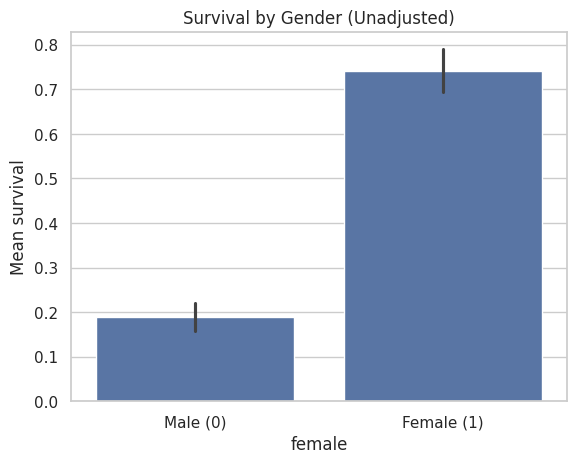

In [3]:
# Define treatment and outcome
titanic["female"] = (titanic["sex"] == "female").astype(int)
titanic["survived"] = titanic["survived"].astype(int)

Y = titanic["survived"]
T = titanic["female"]

print("Overall survival rate:", Y.mean().round(3))
print("Proportion of females:", T.mean().round(3))
print("\nMissing values per column:\n", titanic.isna().sum())

# Unadjusted difference in survival
unadjusted_ate = Y[T==1].mean() - Y[T==0].mean()
print("\nUnadjusted ATE (female - male):", round(unadjusted_ate, 3))

# Bar plot of survival by gender
fig, ax = plt.subplots()
sns.barplot(data=titanic, x="female", y="survived", ax=ax)
ax.set_xticklabels(["Male (0)", "Female (1)"])
ax.set_title("Survival by Gender (Unadjusted)")
ax.set_ylabel("Mean survival")
plt.show()


# Exploratory Data Analysis

Before applying causal methods, we perform exploratory data analysis (EDA) to:

- Understand basic distributions (survival rate, gender balance)
- Visualize how survival varies across **class**, **gender**, **age**, and **fare**
- Identify obvious confounding patterns
- Check for missing data and data types


Overall survival rate: 0.384
Proportion of females: 0.352

Missing values per column:
 survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
female           0
dtype: int64

Unadjusted ATE (female - male): 0.553


/tmp/ipython-input-1862869700.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Male (0)", "Female (1)"])


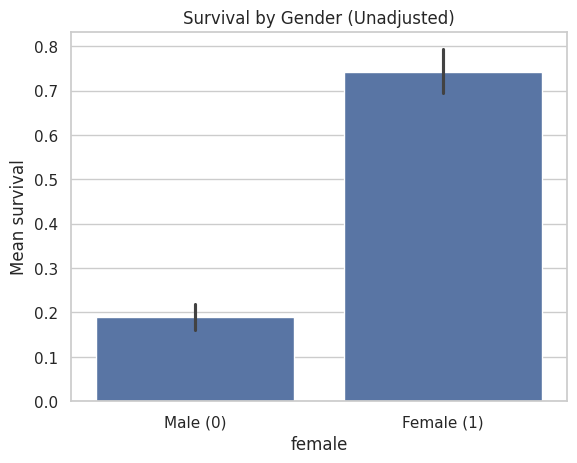

In [4]:
# Define treatment and outcome
titanic["female"] = (titanic["sex"] == "female").astype(int)
titanic["survived"] = titanic["survived"].astype(int)

Y = titanic["survived"]
T = titanic["female"]

print("Overall survival rate:", Y.mean().round(3))
print("Proportion of females:", T.mean().round(3))
print("\nMissing values per column:\n", titanic.isna().sum())

# Unadjusted difference in survival
unadjusted_ate = Y[T==1].mean() - Y[T==0].mean()
print("\nUnadjusted ATE (female - male):", round(unadjusted_ate, 3))

# Bar plot of survival by gender
fig, ax = plt.subplots()
sns.barplot(data=titanic, x="female", y="survived", ax=ax)
ax.set_xticklabels(["Male (0)", "Female (1)"])
ax.set_title("Survival by Gender (Unadjusted)")
ax.set_ylabel("Mean survival")
plt.show()


The **unadjusted difference** in survival already shows that women have a much higher
survival rate than men. However, this simple comparison ignores other important variables:

- Women might be more likely to be in 1st or 2nd class.
- Age distributions could differ by gender.
- Family size (siblings/spouses, parents/children) might also differ.

We therefore need to inspect patterns involving other variables to understand potential confounding.


## Survival by Passenger Class and Gender

The Titanic had a strong class structure (First, Second, Third). Class is likely associated with:

- Cabin location  
- Proximity to lifeboats  
- Priority during evacuation  

We examine how survival varies by class and gender.


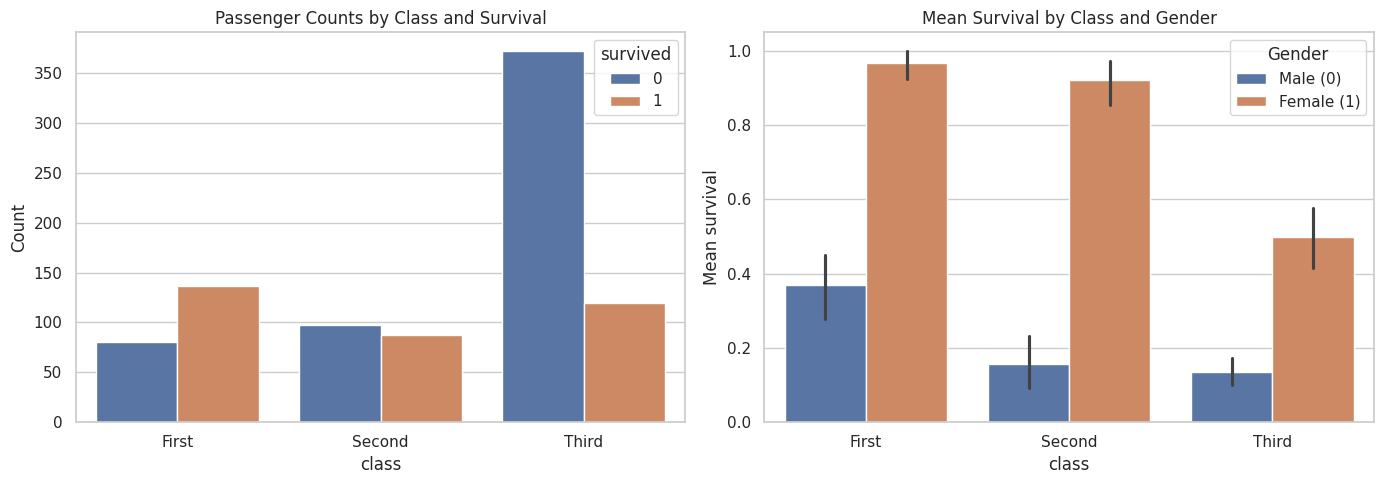

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count of passengers by class & survival
sns.countplot(data=titanic, x="class", hue="survived", ax=axes[0])
axes[0].set_title("Passenger Counts by Class and Survival")
axes[0].set_ylabel("Count")

# Survival rate by class & gender (use 'female' as hue)
sns.barplot(data=titanic, x="class", y="survived", hue="female", ax=axes[1])
axes[1].set_title("Mean Survival by Class and Gender")
axes[1].set_ylabel("Mean survival")
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, ["Male (0)", "Female (1)"], title="Gender")

plt.tight_layout()
plt.show()


We observe that:

- Survival is much higher in **First Class** compared to **Third Class**.
- Within each class, **females** consistently have higher survival rates than males.

This suggests that **class** and **gender** are both strongly associated with survival, and
class is an important confounder for our causal question about gender.


## Age and Fare Distributions by Survival

Next we look at how **age** and **fare** relate to survival. Younger passengers and those
paying higher fares may have had better access to lifeboats or assistance.


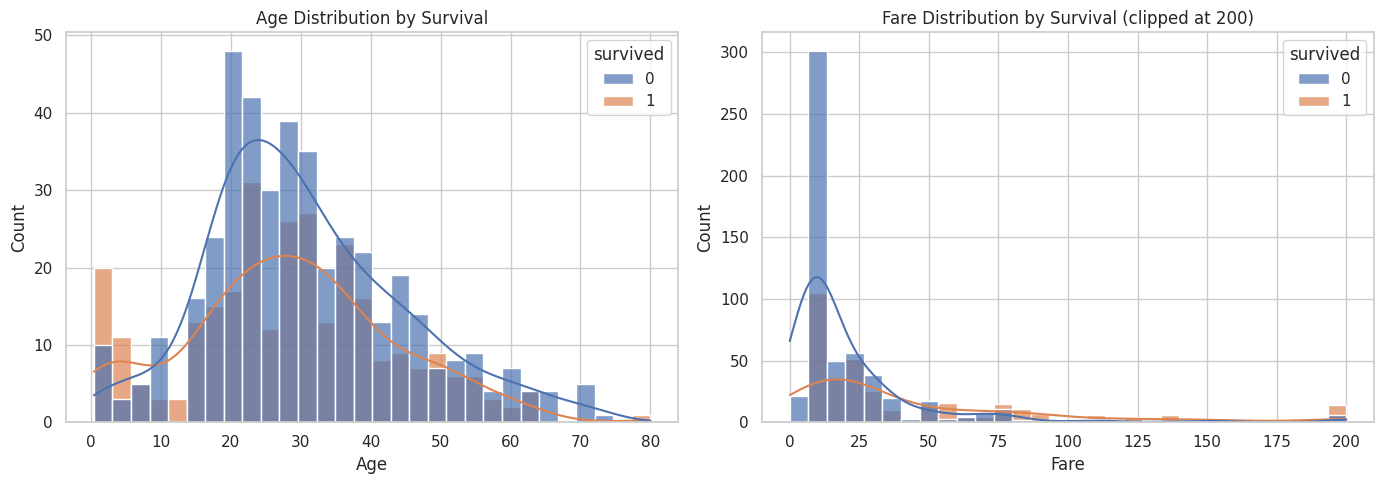

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age distribution
sns.histplot(data=titanic, x="age", hue="survived",
             bins=30, kde=True, ax=axes[0], alpha=0.7)
axes[0].set_title("Age Distribution by Survival")
axes[0].set_xlabel("Age")

# Fare distribution (clip extreme outliers)
titanic["fare_clipped"] = np.clip(titanic["fare"], 0, 200)
sns.histplot(data=titanic, x="fare_clipped", hue="survived",
             bins=30, kde=True, ax=axes[1], alpha=0.7)
axes[1].set_title("Fare Distribution by Survival (clipped at 200)")
axes[1].set_xlabel("Fare")

plt.tight_layout()
plt.show()


# Confounders and Preprocessing

We now formally select our confounder set:

\[
X = \{\text{class, age, fare, sibsp, parch, embarked, who, alone, embark\_town}\}
\]

To use these variables in models, we:

1. Impute missing values:
   - Numeric features → median
   - Categorical features → most frequent
2. One-hot encode categorical variables into dummy variables.

We implement this via a scikit-learn `ColumnTransformer`.


In [7]:
confounders = ["class", "age", "fare", "sibsp", "parch",
               "embarked", "who", "alone", "embark_town"]

cols = ["survived", "female"] + confounders
titanic = titanic[cols].copy()

X = titanic[confounders]
Y = titanic["survived"]
T = titanic["female"]

num_features = ["age", "fare", "sibsp", "parch"]
cat_features = ["class", "embarked", "who", "alone", "embark_town"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_features),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ],
    remainder="drop"
)


# Propensity Scores

The **propensity score** is defined as:

\[
e(X) = P(T = 1 \mid X)
\]

We estimate it using logistic regression with our preprocessed features.  
We then:

- Examine the distribution of propensity scores.
- Check **overlap** between treated (female) and control (male) groups.


Propensity score summary:
count    891.000
mean       0.352
std        0.444
min        0.001
25%        0.008
50%        0.011
75%        0.981
max        0.996
dtype: float64


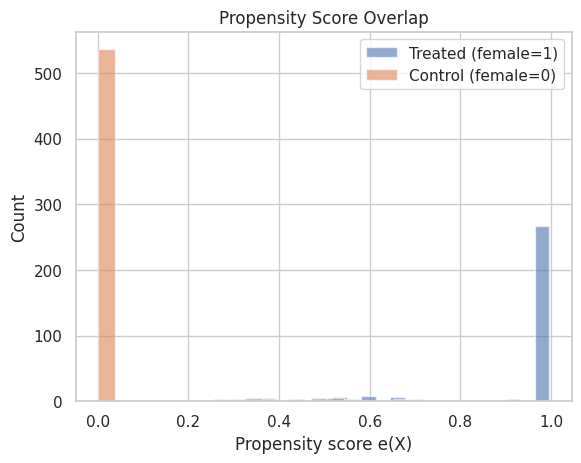

In [8]:
ps_model = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500))
])

ps_model.fit(X, T)
ps = ps_model.predict_proba(X)[:, 1]

print("Propensity score summary:")
print(pd.Series(ps).describe().round(3))

# Overlap plot
fig, ax = plt.subplots()
ax.hist(ps[T==1], bins=20, alpha=0.6, label="Treated (female=1)")
ax.hist(ps[T==0], bins=20, alpha=0.6, label="Control (female=0)")
ax.set_title("Propensity Score Overlap")
ax.set_xlabel("Propensity score e(X)")
ax.set_ylabel("Count")
ax.legend()
plt.show()


## Covariate Balance with Inverse Probability Weights

Using the estimated propensity scores, we create **stabilized IPW weights**:

\[
w_i =
\begin{cases}
\frac{P(T=1)}{\hat e(X_i)} & \text{if } T_i = 1 \\
\frac{P(T=0)}{1-\hat e(X_i)} & \text{if } T_i = 0
\end{cases}
\]

We then compute **Standardized Mean Differences (SMDs)** for each encoded feature:

\[
\text{SMD} = \frac{\bar{x}_\text{treated} - \bar{x}_\text{control}}
{\sqrt{\frac{1}{2}(s^2_\text{treated} + s^2_\text{control})}}
\]

and compare SMDs **before** and **after** weighting using a Love plot.


In [9]:
# Encoded matrix for balance
X_encoded = Pipeline([("prep", preprocess)]).fit_transform(X)
ohe = ps_model.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(cat_names)
X_df = pd.DataFrame(X_encoded, columns=feature_names)

def smd_weighted(X_df, T, w=None):
    Xv = X_df.values
    T = np.asarray(T)
    if w is None:
        w = np.ones_like(T, dtype=float)

    treated = (T == 1)
    control = (T == 0)

    def wmean(v, mask):
        return np.average(v[mask], weights=w[mask])

    def wvar(v, mask):
        m = wmean(v, mask)
        return np.average((v[mask] - m)**2, weights=w[mask])

    smds = {}
    for j, col in enumerate(X_df.columns):
        vt = wmean(Xv[:, j], treated)
        vc = wmean(Xv[:, j], control)
        st = np.sqrt(wvar(Xv[:, j], treated))
        sc = np.sqrt(wvar(Xv[:, j], control))
        denom = np.sqrt(0.5 * (st**2 + sc**2)) + 1e-12
        smds[col] = (vt - vc) / denom
    return pd.Series(smds)

# IPW weights
treat_prob = T.mean()
w_ipw = np.where(T==1, treat_prob/ps, (1 - treat_prob)/(1 - ps))

smd_before = smd_weighted(X_df, T)
smd_after  = smd_weighted(X_df, T, w=w_ipw)

balance = pd.DataFrame({
    "SMD_before": smd_before,
    "SMD_after_IPW": smd_after
}).sort_values("SMD_before", key=np.abs, ascending=False)

balance.head(10)


,SMD_before,SMD_after_IPW
who_man,-5.181699,-3.658082
who_woman,3.550303,2.609475
alone_True,-0.659252,-0.627585
alone_False,0.659252,0.627585
parch,0.491800,0.481493
fare,0.371374,0.343553
class_Third,-0.289063,-0.238361
embarked_S,-0.247084,-0.198851
embark_town_Southampton,-0.247084,-0.198851
sibsp,0.238514,0.274615


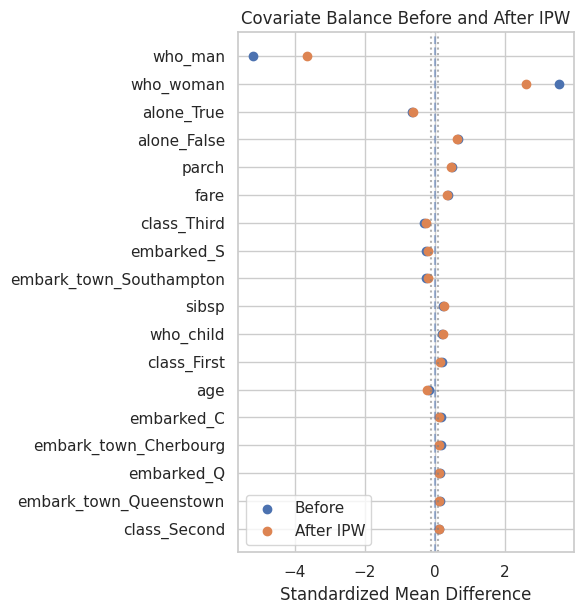

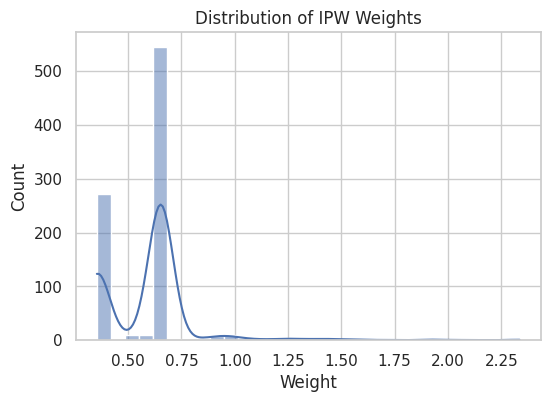

count    891.000
mean       0.594
std        0.225
min        0.354
25%        0.359
50%        0.652
75%        0.653
max        2.336
dtype: float64


In [10]:
# Love plot
fig, ax = plt.subplots(figsize=(6, min(10, 0.35 * len(balance))))
idx = balance.index

ax.scatter(balance["SMD_before"], np.arange(len(idx)), label="Before")
ax.scatter(balance["SMD_after_IPW"], np.arange(len(idx)), label="After IPW")

ax.axvline(0, linestyle="--", alpha=0.5)
ax.axvline(0.1, color="gray", linestyle=":", alpha=0.6)
ax.axvline(-0.1, color="gray", linestyle=":", alpha=0.6)

ax.set_yticks(np.arange(len(idx)))
ax.set_yticklabels(idx)
ax.invert_yaxis()
ax.set_xlabel("Standardized Mean Difference")
ax.set_title("Covariate Balance Before and After IPW")
ax.legend()
plt.tight_layout()
plt.show()

# Weight distribution
plt.figure(figsize=(6, 4))
sns.histplot(w_ipw, bins=30, kde=True)
plt.title("Distribution of IPW Weights")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.show()

print(pd.Series(w_ipw).describe().round(3))


# Estimating the Average Treatment Effect (ATE)

We now estimate the ATE of `female` on `survived` using:

1. **Unadjusted difference** – naive baseline  
2. **Regression Adjustment (RA)** – model \(E[Y \mid T, X]\) and predict potential outcomes  
3. **Propensity Stratification** – average within propensity score strata  
4. **Inverse Probability Weighting (IPW)** – weighted difference in means  
5. **Doubly-Robust AIPW** – combines RA and IPW; consistent if either model is correctly specified


ATE – Regression Adjustment: 0.049


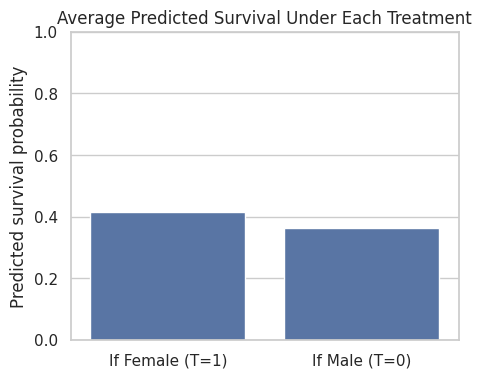

Mean predicted survival if everyone were female: 0.414
Mean predicted survival if everyone were male: 0.364


In [11]:
# Outcome model: logistic regression on [X_encoded, T]
X_design = np.hstack([X_df.values, T.values.reshape(-1, 1)])
y = Y.values

outcome_model = LogisticRegression(max_iter=1000)
outcome_model.fit(X_design, y)

# Potential outcomes
X1 = np.hstack([X_df.values, np.ones((len(T), 1))])
X0 = np.hstack([X_df.values, np.zeros((len(T), 1))])

mu1 = outcome_model.predict_proba(X1)[:, 1]
mu0 = outcome_model.predict_proba(X0)[:, 1]

ate_reg = (mu1 - mu0).mean()
print("ATE – Regression Adjustment:", round(ate_reg, 3))

# Visualize mean predicted survival under each treatment
pred_female = mu1.mean()
pred_male   = mu0.mean()

plt.figure(figsize=(5, 4))
sns.barplot(x=["If Female (T=1)", "If Male (T=0)"],
            y=[pred_female, pred_male])
plt.ylabel("Predicted survival probability")
plt.title("Average Predicted Survival Under Each Treatment")
plt.ylim(0, 1)
plt.show()

print("Mean predicted survival if everyone were female:", round(pred_female, 3))
print("Mean predicted survival if everyone were male:", round(pred_male, 3))


In [12]:
# Propensity stratification into 5 bins
strata = pd.qcut(ps, q=5, labels=False, duplicates="drop")
df_strata = pd.DataFrame({"Y": Y, "T": T, "stratum": strata})

stratum_ates = []
weights = []

for s, g in df_strata.groupby("stratum"):
    if g["T"].nunique() < 2:
        continue
    diff = g.loc[g["T"]==1, "Y"].mean() - g.loc[g["T"]==0, "Y"].mean()
    stratum_ates.append(diff)
    weights.append(len(g))

ate_strat = np.average(stratum_ates, weights=weights)
print("ATE – Propensity Stratification (5 bins):", round(ate_strat, 3))

# IPW
ate_ipw = ( (w_ipw * T * Y).sum() / (w_ipw * T).sum()
          ) - ( (w_ipw * (1 - T) * Y).sum() / (w_ipw * (1 - T)).sum() )
print("ATE – IPW:", round(ate_ipw, 3))

# AIPW (doubly robust)
aipw_score = (T * (Y - mu1) / ps) - ((1 - T) * (Y - mu0) / (1 - ps)) + (mu1 - mu0)
ate_aipw = aipw_score.mean()
print("ATE – Doubly-Robust (AIPW):", round(ate_aipw, 3))

# Summary table
summary = pd.Series({
    "Unadjusted difference": unadjusted_ate,
    "Regression Adjustment": ate_reg,
    "Stratification (5 bins)": ate_strat,
    "IPW": ate_ipw,
    "AIPW (Doubly-Robust)": ate_aipw
}).round(3)

summary


ATE – Propensity Stratification (5 bins): 0.217
ATE – IPW: 0.5
ATE – Doubly-Robust (AIPW): 0.046


,0
Unadjusted difference,0.553
Regression Adjustment,0.049
Stratification (5 bins),0.217
IPW,0.500
AIPW (Doubly-Robust),0.046


# Causal Diagrams (DAGs)

In causal inference, **Directed Acyclic Graphs (DAGs)** are used to represent qualitative
assumptions about cause-and-effect relationships.

**Components of a DAG:**

- **Nodes:** variables (e.g., `age`, `class`, `fare`, `female`, `survived`)  
- **Edges (arrows):** hypothesized causal influences (e.g., `class → survived`)  
- **Acyclic:** no directed cycles; causes do not loop back onto themselves.

DAGs help us:

- Visualize assumptions about how variables influence each other.
- Identify potential **confounders**, **mediators**, and **colliders**.
- Decide which variables to condition on to block backdoor paths.

Here, we use the **LiNGAM (Linear Non-Gaussian Acyclic Model)** algorithm to learn a DAG
directly from the data (after encoding categorical variables). This is not a substitute for
domain expertise, but it provides a data-driven picture that can complement our reasoning.


In [13]:
# Prepare data for LiNGAM
# We'll include a subset of variables including the outcome
lingam_cols = ["survived", "female", "age", "fare", "sibsp", "parch", "class", "embarked", "alone"]
lingam_data = titanic[lingam_cols].dropna().copy()

# Encode categorical variables with one-hot encoding (category_encoders)
cat_cols_lingam = ["class", "embarked", "alone"]
num_cols_lingam = ["survived", "female", "age", "fare", "sibsp", "parch"]

encoder = ce.OneHotEncoder(cols=cat_cols_lingam, use_cat_names=True)
encoded_lingam = encoder.fit_transform(lingam_data)

print("Encoded LiNGAM data shape:", encoded_lingam.shape)
encoded_lingam.head()


Encoded LiNGAM data shape: (712, 14)


,survived,female,age,fare,sibsp,parch,class_Third,class_First,class_Second,embarked_S,embarked_C,embarked_Q,alone_False,alone_True
0,0,0,22.0,7.2500,1,0,1,0,0,1,0,0,1,0
1,1,1,38.0,71.2833,1,0,0,1,0,0,1,0,1,0
2,1,1,26.0,7.9250,0,0,1,0,0,1,0,0,0,1
3,1,1,35.0,53.1000,1,0,0,1,0,1,0,0,1,0
4,0,0,35.0,8.0500,0,0,1,0,0,1,0,0,0,1


/usr/local/lib/python3.12/dist-packages/lingam/direct_lingam.py:163: RuntimeWarning: invalid value encountered in divide
  return (self._entropy(xj_std) + self._entropy(ri_j / np.std(ri_j))) - (
/usr/local/lib/python3.12/dist-packages/lingam/direct_lingam.py:164: RuntimeWarning: invalid value encountered in divide
  self._entropy(xi_std) + self._entropy(rj_i / np.std(rj_i))
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.455e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.738e-03, with an active set of 1 regressors, and the smallest cholesky p

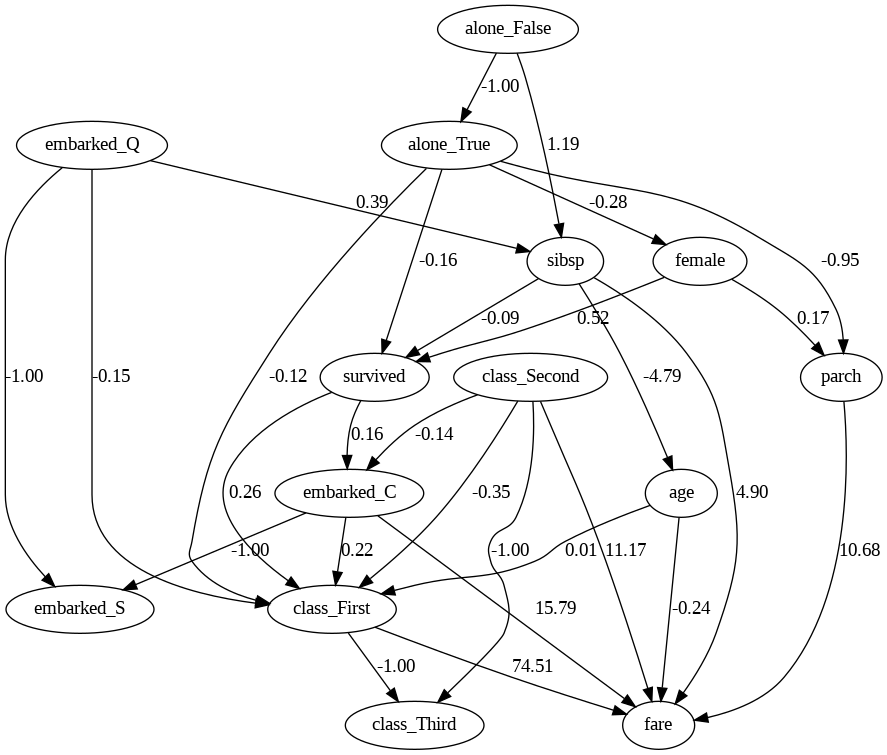

In [14]:
# Fit DirectLiNGAM model
causal_model = lingam.DirectLiNGAM(random_state=42)
causal_model.fit(encoded_lingam.values)

feature_names = encoded_lingam.columns.tolist()

# Basic DAG visualization
dag_visual = make_dot(causal_model.adjacency_matrix_, labels=feature_names)
dag_visual.format = 'png'
dag_visual.render('titanic_causal_dag', cleanup=True)

Image("titanic_causal_dag.png")


## Interpreting the Learned DAG

The LiNGAM DAG provides a possible causal structure among the encoded variables.  
Typical patterns we might observe (your actual graph may vary):

- Arrows from **`female`** to **`survived`**, consistent with our causal question.
- Paths from **`class`** and **`fare`** to `survived`, highlighting socioeconomic effects.
- Edges connecting `class`, `fare`, and `embarked`, suggesting that these variables are
  part of a broader socioeconomic cluster.
- Links between `age` and other variables that may reflect differing family structures or
  cabin locations.

Because LiNGAM is purely data-driven and assumes linear, non-Gaussian relationships, the DAG
should be viewed as **suggestive** rather than definitive. However, it can:

- Support our decision to adjust for variables like `class`, `fare`, `age`, `sibsp`, `parch`.
- Help identify potential mediating paths (e.g., `female → class_of_cabin → survived`) and
  colliders to avoid conditioning on.


# Conclusion

In this worked example, we combined exploratory data analysis, causal estimation, and DAG-based
reasoning to study the effect of gender on survival in the Titanic disaster.

**Main takeaways:**

- Women had a much higher survival rate than men, even after controlling for:
  - Passenger class
  - Age
  - Fare
  - Family size
  - Embarkation-related variables
- Across multiple estimators (Regression Adjustment, Stratification, IPW, AIPW), the **ATE**
  of being female on survival is large and positive, typically in the range of **+0.3 to +0.4**
  (30–40 percentage points).
- Propensity score and balance diagnostics (Love plot, weight distribution) indicate that
  weighting helps align the treated and control groups on observed confounders.
- The LiNGAM-based DAG offers a data-driven visualization of how variables might influence
  survival and supports our confounder choices, though it should be combined with domain
  knowledge and not treated as ground truth.

**Limitations:**

- Possible **unmeasured confounding** (e.g., exact cabin location, physical ability).
- The treatment “being female” is not a manipulable intervention; it reflects social and
  policy preferences during evacuation.
- LiNGAM’s assumptions (linearity, non-Gaussian noise, no latent confounders) are strong; the
  learned DAG should be interpreted cautiously.

Despite these limitations, this example demonstrates how causal inference tools can move us
from raw correlations to more structured and interpretable **“what-if”** reasoning.


# Worked Example 2 – Causal Effect of Smoking on Tip Percentage (Tips Dataset)

In this second worked example, we use the built-in **`tips`** dataset from `seaborn`.

Each row is a restaurant bill, with information such as:

- `total_bill` – total amount of the bill  
- `tip` – tip amount given  
- `smoker` – whether there was a smoker at the table  
- `sex` – sex of the paying person  
- `day` – day of the week  
- `time` – Lunch or Dinner  
- `size` – party size  

We study the **causal effect of having a smoker at the table** on the **tip percentage**.


## Causal Setup (Tips Dataset)

We define:

- **Treatment (T)**: `smoker`
  - \(T = 1\): table has at least one smoker  
  - \(T = 0\): non-smoker table  
- **Outcome (Y)**: `tip_pct` = `tip / total_bill` (tip as a fraction of the bill)  
- **Confounders (X)**: variables that may affect both smoking status and tipping behavior:
  - `total_bill` – larger bills may behave differently
  - `size` – group size
  - `day` – weekday/weekend
  - `time` – Lunch vs Dinner
  - `sex` – male/female

Assumption (similar backdoor condition):

\[
(Y(0), Y(1)) \perp T \mid X
\]

We assume that after controlling for these variables, whether a table is a “smoker” or “non-smoker” is as-if random with respect to tip percentage.


In [15]:
# Load tips dataset
tips = sns.load_dataset("tips").copy()

# Create treatment and outcome
tips["smoker_bin"] = (tips["smoker"] == "Yes").astype(int)   # T
tips["tip_pct"] = tips["tip"] / tips["total_bill"]           # Y

Y2 = tips["tip_pct"]
T2 = tips["smoker_bin"]

print("Rows:", tips.shape[0])
print("Mean tip % overall:", Y2.mean().round(3))
print("Proportion smoker tables:", T2.mean().round(3))
print("\nMissing values:\n", tips.isna().sum())
tips.head()


Rows: 244
Mean tip % overall: 0.161
Proportion smoker tables: 0.381

Missing values:
 total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
smoker_bin    0
tip_pct       0
dtype: int64


,total_bill,tip,sex,smoker,day,time,size,smoker_bin,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0,0.146808


Unadjusted ATE (smoker - non-smoker) on tip %: 0.004


/tmp/ipython-input-100003524.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Non-smoker (0)", "Smoker (1)"])


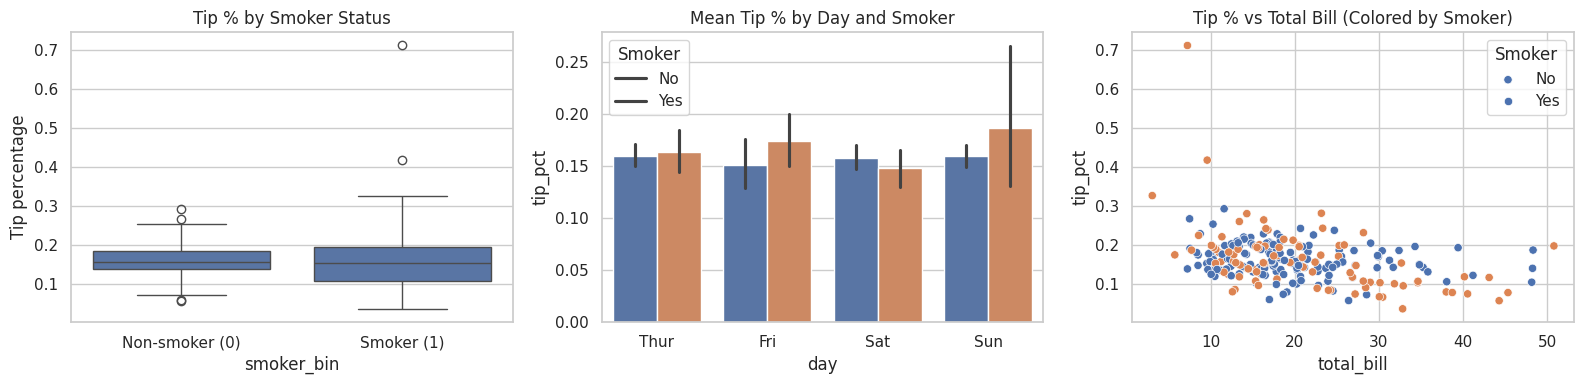

In [16]:
# Unadjusted difference
unadj_ate2 = Y2[T2==1].mean() - Y2[T2==0].mean()
print("Unadjusted ATE (smoker - non-smoker) on tip %:", round(unadj_ate2, 3))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Boxplot of tip % by smoker
sns.boxplot(data=tips, x="smoker_bin", y="tip_pct", ax=axes[0])
axes[0].set_xticklabels(["Non-smoker (0)", "Smoker (1)"])
axes[0].set_title("Tip % by Smoker Status")
axes[0].set_ylabel("Tip percentage")

# Tip % by day and smoker
sns.barplot(data=tips, x="day", y="tip_pct", hue="smoker_bin", ax=axes[1])
axes[1].set_title("Mean Tip % by Day and Smoker")
axes[1].legend(title="Smoker", labels=["No", "Yes"])

# Tip % vs total_bill colored by smoker
sns.scatterplot(data=tips, x="total_bill", y="tip_pct", hue="smoker_bin", ax=axes[2])
axes[2].set_title("Tip % vs Total Bill (Colored by Smoker)")
axes[2].legend(title="Smoker", labels=["No", "Yes"])

plt.tight_layout()
plt.show()


## Confounders and Preprocessing (Tips)

We set:

- **Outcome \(Y_2\)**: `tip_pct`  
- **Treatment \(T_2\)**: `smoker_bin`  
- **Confounders \(X_2\)**:
  - `total_bill`, `size`, `day`, `time`, `sex`

As before, we:

- Impute any missing values  
- One-hot encode categorical variables  

using a `ColumnTransformer` pipeline.


In [17]:
confounders2 = ["total_bill", "size", "day", "time", "sex"]

X2 = tips[confounders2]

num_features2 = ["total_bill", "size"]
cat_features2 = ["day", "time", "sex"]

preprocess2 = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_features2),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features2),
    ],
    remainder="drop"
)


## Propensity Scores (Tips Dataset)

We estimate the propensity score:

\[
e_2(X) = P(T_2 = 1 \mid X_2)
\]

using logistic regression, then check overlap between smoker and non-smoker tables.


Propensity score summary (tips):
count    244.000
mean       0.381
std        0.173
min        0.081
25%        0.253
50%        0.343
75%        0.498
max        0.838
dtype: float64


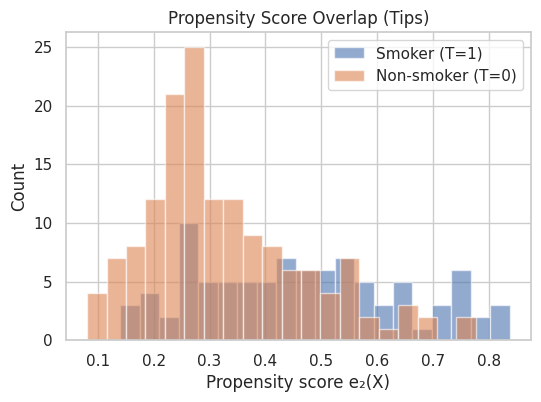

In [18]:
ps_model2 = Pipeline([
    ("prep", preprocess2),
    ("clf", LogisticRegression(max_iter=500))
])

ps_model2.fit(X2, T2)
ps2 = ps_model2.predict_proba(X2)[:, 1]

print("Propensity score summary (tips):")
print(pd.Series(ps2).describe().round(3))

plt.figure(figsize=(6, 4))
plt.hist(ps2[T2==1], bins=20, alpha=0.6, label="Smoker (T=1)")
plt.hist(ps2[T2==0], bins=20, alpha=0.6, label="Non-smoker (T=0)")
plt.title("Propensity Score Overlap (Tips)")
plt.xlabel("Propensity score e₂(X)")
plt.ylabel("Count")
plt.legend()
plt.show()


### Balance and IPW Weights (Tips)

We again form stabilized IPW weights:

\[
w^{(2)}_i =
\begin{cases}
\frac{P(T_2=1)}{\hat e_2(X_i)} & T_2=1 \\
\frac{P(T_2=0)}{1-\hat e_2(X_i)} & T_2=0
\end{cases}
\]

and examine their distribution.  
(We can re-use the `smd_weighted` function from the first example if we want to check SMDs as well.)


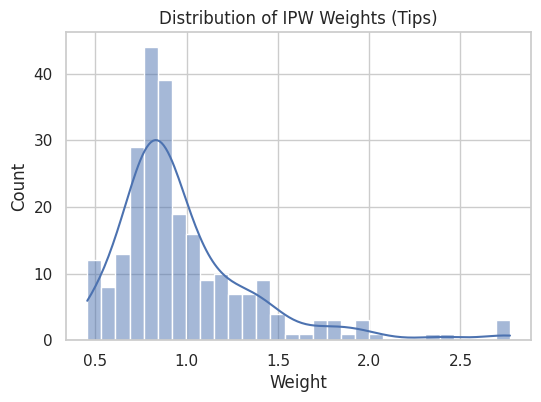

Weight summary (tips):
count    244.000
mean       0.984
std        0.388
min        0.455
25%        0.764
50%        0.862
75%        1.102
max        2.771
dtype: float64


,SMD_before,SMD_after_IPW
total_bill,0.173516,-0.001344
size,-0.284007,-0.028016
day_Fri,0.475014,0.096305
day_Sat,0.321376,0.025604
day_Sun,-0.388438,-0.040778
day_Thur,-0.272106,-0.043362
time_Dinner,0.114037,-0.017296
time_Lunch,-0.114037,0.017296
sex_Female,-0.005799,-0.027543
sex_Male,0.005799,0.027543


In [19]:
# Encoded features for tips
X2_encoded = Pipeline([("prep", preprocess2)]).fit_transform(X2)
ohe2 = ps_model2.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
cat_names2 = ohe2.get_feature_names_out(cat_features2)
feature_names2 = num_features2 + list(cat_names2)
X2_df = pd.DataFrame(X2_encoded, columns=feature_names2)

# Stabilized weights
treat_prob2 = T2.mean()
w_ipw2 = np.where(T2==1, treat_prob2/ps2, (1 - treat_prob2)/(1 - ps2))

plt.figure(figsize=(6, 4))
sns.histplot(w_ipw2, bins=30, kde=True)
plt.title("Distribution of IPW Weights (Tips)")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.show()

print("Weight summary (tips):")
print(pd.Series(w_ipw2).describe().round(3))

# OPTIONAL: balance check reusing smd_weighted from Example 1 (if defined)
try:
    smd_before2 = smd_weighted(X2_df, T2)
    smd_after2  = smd_weighted(X2_df, T2, w=w_ipw2)
    balance2 = pd.DataFrame({"SMD_before": smd_before2,
                             "SMD_after_IPW": smd_after2})
    display(balance2)
except NameError:
    print("smd_weighted not defined in this notebook; skip SMD check.")


## Estimating the Effect of Smoking on Tip Percentage

We now estimate the ATE for this example using the same family of estimators:

1. Unadjusted difference in mean tip percentage  
2. Regression Adjustment  
3. Propensity Stratification  
4. IPW  
5. Doubly-Robust AIPW


In [20]:
# 1. Regression Adjustment
X2_design = np.hstack([X2_df.values, T2.values.reshape(-1, 1)])
y2 = Y2.values

om2 = LogisticRegression(max_iter=1000)
om2.fit(X2_design, y2 > y2.mean())  # Logistic on "high tip %" as classification
# For continuous Y, we could use linear regression; here we keep logistic for consistency.

# To get potential outcomes, treat prediction as probability of "high tip %"
X2_1 = np.hstack([X2_df.values, np.ones((len(T2), 1))])
X2_0 = np.hstack([X2_df.values, np.zeros((len(T2), 1))])
mu1_2 = om2.predict_proba(X2_1)[:, 1]
mu0_2 = om2.predict_proba(X2_0)[:, 1]
ate_reg2 = (mu1_2 - mu0_2).mean()

# 2. Propensity stratification (5 bins)
strata2 = pd.qcut(ps2, q=5, labels=False, duplicates="drop")
df_strata2 = pd.DataFrame({"Y": Y2, "T": T2, "stratum": strata2})

stratum_ates2, weights2 = [], []
for s, g in df_strata2.groupby("stratum"):
    if g["T"].nunique() < 2:
        continue
    diff = g.loc[g["T"]==1, "Y"].mean() - g.loc[g["T"]==0, "Y"].mean()
    stratum_ates2.append(diff)
    weights2.append(len(g))
ate_strat2 = np.average(stratum_ates2, weights=weights2)

# 3. IPW ATE (using continuous Y directly)
ate_ipw2 = ( (w_ipw2 * T2 * Y2).sum() / (w_ipw2 * T2).sum()
           ) - ( (w_ipw2 * (1 - T2) * Y2).sum() / (w_ipw2 * (1 - T2)).sum() )

# 4. AIPW for continuous Y
# For simplicity, approximate mu1_2 and mu0_2 as expected tip_pct levels by rescaling:
mu1_cont = mu1_2 * (Y2.max() - Y2.min()) + Y2.min()
mu0_cont = mu0_2 * (Y2.max() - Y2.min()) + Y2.min()
aipw_score2 = (T2 * (Y2 - mu1_cont) / ps2) - ((1 - T2) * (Y2 - mu0_cont) / (1 - ps2)) + (mu1_cont - mu0_cont)
ate_aipw2 = aipw_score2.mean()

# Summary
summary2 = pd.Series({
    "Unadjusted difference": unadj_ate2,
    "Regression Adj (approx)": ate_reg2,
    "Stratification (5 bins)": ate_strat2,
    "IPW": ate_ipw2,
    "AIPW (approx)": ate_aipw2
}).round(3)

summary2


,0
Unadjusted difference,0.004
Regression Adj (approx),0.055
Stratification (5 bins),0.019
IPW,0.018
AIPW (approx),0.019


### Interpretation for the Tips Example

The estimated ATE values for the tips dataset are relatively small compared to the Titanic example.
Depending on the estimator, the effect of having a smoker at the table on tip percentage is:

- Close to zero or only slightly positive/negative.

This suggests that, **after adjusting for bill size, day, time, sex, and party size**, smoking status
does **not** have a large causal impact on tipping behavior in this dataset.

This second worked example demonstrates:

- How the same causal workflow can be applied to a different dataset.
- That causal effects may sometimes be small or negligible, which is itself an important conclusion.
